In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for pipelines and grid search
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

# Dimensionality Reduction algoriths
from sklearn.decomposition import PCA, KernelPCA
from sklearn.feature_selection import RFE
from sklearn.manifold import LocallyLinearEmbedding

# Classification algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Metrics for evaluating classification models
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

import shap

import datetime

import random

import warnings
warnings.filterwarnings("ignore")

### 1. Exploratory Data Analysis

In [145]:
# Import the raw data from clinical and cnrq/miRNA samples data files

df_clinical = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\ICORG database for analysis 2021 - clinical - CSV.csv")

df_cnrq = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\ICORG database for analysis 2021 - cnrq - CSV.csv")

df_cnrq.drop('Unnamed: 17', axis=1, inplace=True)

In [146]:
# Take a look at the the two data frames

df_clinical.head()

Patient No.   Age ER Status PR Status HER2 Status Tumour Subtype  \
0          1.0  67.0  Positive  Negative    Negative      Luminal A   
1          2.0  53.0  Positive  Positive    Negative      Luminal A   
2          3.0  65.0  Positive  Positive    Negative      Luminal A   
3          4.0   NaN  Positive  Negative    Positive      Luminal B   
4          5.0   NaN  Positive  Positive    Positive      Luminal B   

  Node Result  Mammogram Size  Tumour Grade Surgical Procedure  \
0    Negative             NaN           2.0                WLE   
1         NaN             4.0           2.0                WLE   
2    Positive             7.0           2.0                WLE   
3    Positive             7.0           2.0         Mastectomy   
4    Negative             NaN           2.0         Mastectomy   

   Invasive Tumour size on histology (cm) Tumour bed response to NACT  \
0                                     3.0                     Partial   
1                                     6.3                     Partial   
2                                     4.0                     Partial   
3                                     3.8                        Good   
4                                     1.4                        Good   

   Number of Nodes Involved Final combined pCR status   NPI  Mammographic NPI  
0                       5.0                        No  5.60               NaN  
1                       3.0                        No  6.26               4.8  
2                      13.0                        No  5.60               6.4  
3                       4.0                        No  5.76               6.4  
4                       0.0                        No  3.28               NaN

In [147]:
df_cnrq.head()

Samples Let-7a CNRQ Let-7a SE(CNRQ) miR-10b CNRQ miR-10b SE(CNRQ)  \
0     1-1    0.619542        0.043492    -0.258232         0.022169   
1     1-2    0.268956        0.031020     0.466741         0.037892   
2     1-3   -0.330399        0.038581    -0.271332         0.038458   
3     1-4    1.202915        0.019768     1.314104         0.016260   
4     1-5    0.668195        0.029424     0.473851         0.031627   

  miR-145 CNRQ miR-145 SE(CNRQ) miR-155 CNRQ miR-155 SE(CNRQ) miR-16 CNRQ  \
0     0.248945         0.032727    -1.948633         0.038655    0.245929   
1     0.688605         0.029129          NaN              NaN    0.249567   
2     0.354952         0.031385     0.057162         0.040371   -0.265812   
3     1.859136         0.038551     1.561874         0.019562    1.117200   
4     0.841119         0.025823    -3.370786         0.045068    0.241619   

  miR-16 SE(CNRQ) miR-195 CNRQ miR-195 SE(CNRQ) miR-21 CNRQ miR-21 SE(CNRQ)  \
0        0.010475     0.756180         0.012659    0.588606        0.013795   
1        0.014383     0.528927         0.020011    0.631142        0.028848   
2        0.021709    -0.283067         0.029393   -0.297470        0.036457   
3        0.010158    -0.496248         0.030897    1.799202        0.025332   
4        0.035241     0.713116         0.020807    0.788514        0.039980   

  miR-425 CNRQ miR-425 SE(CNRQ)  
0    -0.245929         0.014497  
1    -0.249567         0.020417  
2     0.265812         0.027783  
3    -1.117200         0.019028  
4    -0.241619         0.024060

In [148]:
# Create two new features by splitting the "Sample" feature into "Patient No." and "Sample No."
df_cnrq.insert(0,'Patient No.',df_cnrq.Samples.str.split('-').str[0])
df_cnrq.insert(1,'Sample No.',df_cnrq.Samples.str.split('-').str[1])
df_cnrq.drop('Samples', axis=1, inplace=True)

idxs = list(df_cnrq.columns)[0:2]
cols = list(df_cnrq.columns)[2:]

df_cnrq[idxs] = df_cnrq[idxs].apply(pd.to_numeric, errors='coerce', axis=1)
df_cnrq[cols] = df_cnrq[cols].apply(pd.to_numeric, errors='coerce', axis=1)

df_clinical['Patient No.'] = df_clinical['Patient No.'].apply(pd.to_numeric, errors='coerce')

In [149]:
# Each patient has up to 5 sample rows for each miRNA measurement so we need to denormalise before joining

f_cnrq_denorm = pd.DataFrame()

# Denormalisation routine

for x in range(1, 6):
    temp_df = df_cnrq[(df_cnrq['Sample No.'] == x)].copy()
    
    cols = temp_df.columns[2:]
    
    for col in cols:
        new_col = "Sample_" + str(x) + "_" + col
        temp_df.rename(columns = {col:new_col}, inplace = True)

    temp_df.drop('Sample No.', axis=1, inplace=True)
    temp_df.set_index('Patient No.')
    
    if x > 1:
        df_cnrq_denorm = pd.merge(df_cnrq_denorm, temp_df, how='left', on='Patient No.')

    else:
        df_cnrq_denorm = temp_df.copy()   

# Join datasets
df = pd.merge(df_clinical, df_cnrq_denorm, on='Patient No.', how='left')

In [150]:
# Drop rows with all columns data missing values

df = df.dropna(how='all')

In [151]:
# Based on discussion with James, columns with'_miR_10' can be deleted as well as all of Sample 5

del_col_names = ['Sample_1_miR-10b CNRQ', 'Sample_1_miR-10b SE(CNRQ)',
                 'Sample_2_miR-10b CNRQ', 'Sample_2_miR-10b SE(CNRQ)',
                 'Sample_3_miR-10b CNRQ', 'Sample_3_miR-10b SE(CNRQ)',
                 'Sample_4_miR-10b CNRQ', 'Sample_4_miR-10b SE(CNRQ)',
                 'Sample_5_miR-10b CNRQ', 'Sample_5_miR-10b SE(CNRQ)'
                ]
df = df.drop(del_col_names, axis=1)

# Drop columns from Sample 5

df = df.drop(df.filter(regex='Sample_[2-5]').columns, axis=1)

df = df.drop(df.filter(regex='Unnamed').columns, axis=1)

In [152]:
df.columns

Index(['Patient No.', 'Age', 'ER Status', 'PR Status', 'HER2 Status',
       'Tumour Subtype', 'Node Result', 'Mammogram Size', 'Tumour Grade',
       'Surgical Procedure', 'Invasive Tumour size on histology (cm)',
       'Tumour bed response to NACT', 'Number of Nodes Involved',
       'Final combined pCR status', 'NPI', 'Mammographic NPI',
       'Sample_1_Let-7a CNRQ', 'Sample_1_Let-7a SE(CNRQ)',
       'Sample_1_miR-145 CNRQ', 'Sample_1_miR-145 SE(CNRQ)',
       'Sample_1_miR-155 CNRQ', 'Sample_1_miR-155 SE(CNRQ)',
       'Sample_1_miR-16 CNRQ', 'Sample_1_miR-16 SE(CNRQ)',
       'Sample_1_miR-195 CNRQ', 'Sample_1_miR-195 SE(CNRQ)',
       'Sample_1_miR-21 CNRQ', 'Sample_1_miR-21 SE(CNRQ)',
       'Sample_1_miR-425 CNRQ', 'Sample_1_miR-425 SE(CNRQ)'],
      dtype='object')

In [153]:
# Reset all 'missing' values with standard NaN

df = df.replace('Missing', np.NaN)

In [154]:
# Dropping 'PR Status' and 'Tumour Subtype' because of strong correlations on Spearman Matrix

drop_cols = ['PR Status', 'Tumour Subtype','Mammographic NPI', 'Patient No.']

df = df.drop(drop_cols, axis=1)

In [155]:
df.shape

(124, 26)

In [156]:
# Summary statistics on numeric data

df.describe()

Age  Mammogram Size  Tumour Grade  \
count  102.000000       89.000000    122.000000   
mean    55.088235        4.173034      2.459016   
std     10.599928        2.065670      0.516625   
min     25.000000        0.800000      1.000000   
25%     48.000000        2.800000      2.000000   
50%     55.000000        3.700000      2.000000   
75%     63.000000        5.000000      3.000000   
max     76.000000       10.000000      3.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                              116.000000                120.000000   
mean                                 2.423190                  2.916667   
std                                  3.442705                  5.389974   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  1.350000                  0.000000   
75%                                  3.850000                  3.250000   
max                                 24.000000                 26.000000   

              NPI  Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  \
count  111.000000            112.000000                112.000000   
mean     4.659730             -0.079412                  0.026967   
std      1.208609              0.732854                  0.012864   
min      2.380000             -3.099901                  0.008775   
25%      4.000000             -0.465806                  0.017465   
50%      4.280000              0.007653                  0.024258   
75%      5.310000              0.349460                  0.035144   
max      9.800000              1.606284                  0.101109   

       Sample_1_miR-145 CNRQ  Sample_1_miR-145 SE(CNRQ)  \
count             111.000000                 111.000000   
mean                0.008271                   0.028359   
std                 0.578259                   0.014445   
min                -2.286769                   0.003589   
25%                -0.336913                   0.017690   
50%                 0.142475                   0.026165   
75%                 0.386108                   0.035616   
max                 1.287875                   0.103618   

       Sample_1_miR-155 CNRQ  Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count             113.000000                 113.000000            116.000000   
mean               -0.154860                   0.027256              0.006177   
std                 0.835144                   0.013255              0.292226   
min                -4.049647                   0.004295             -0.722485   
25%                -0.339528                   0.018420             -0.164788   
50%                 0.000212                   0.026023             -0.008289   
75%                 0.228773                   0.034086              0.191508   
max                 2.219914                   0.102839              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                116.000000             113.000000   
mean                   0.021113              -0.045760   
std                    0.013447               0.583540   
min                    0.001627              -2.272715   
25%                    0.012525              -0.290821   
50%                    0.018521               0.079972   
75%                    0.025076               0.357126   
max                    0.103076               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                 113.000000            113.000000   
mean                    0.024106             -0.175079   
std                     0.012219              0.795284   
min                     0.008899             -4.472507   
25%                     0.016539             -0.347641   
50%                     0.021701             -0.100311   
75%                     0.029127              0.269272   
max    

In [157]:
# Calculate the percentage of missing data for each feature

pd.set_option("display.max_rows", None, "display.max_columns", None)
df.isna().sum()/df.shape[0]*100

Age                                       17.741935
ER Status                                  0.000000
HER2 Status                                0.000000
Node Result                               27.419355
Mammogram Size                            28.225806
Tumour Grade                               1.612903
Surgical Procedure                         1.612903
Invasive Tumour size on histology (cm)     6.451613
Tumour bed response to NACT                3.225806
Number of Nodes Involved                   3.225806
Final combined pCR status                  3.225806
NPI                                       10.483871
Sample_1_Let-7a CNRQ                       9.677419
Sample_1_Let-7a SE(CNRQ)                   9.677419
Sample_1_miR-145 CNRQ                     10.483871
Sample_1_miR-145 SE(CNRQ)                 10.483871
Sample_1_miR-155 CNRQ                      8.870968
Sample_1_miR-155 SE(CNRQ)                  8.870968
Sample_1_miR-16 CNRQ                       6.451613
Sample_1_miR

In [158]:
# Plot the distribution of categorical features to determine class imbalance

all_cols = df.columns
cols = df.select_dtypes(include='number').columns

cat_cols = list(set(all_cols) - set(cols))

for cat in cat_cols:
    cnt = df[cat].count()
    num_elem = (df.groupby([cat])[cat].count())/cnt*100
    print (num_elem, '\n')

Final combined pCR status
No     73.333333
Yes    26.666667
Name: Final combined pCR status, dtype: float64 

Surgical Procedure
Mastectomy    44.262295
WLE           55.737705
Name: Surgical Procedure, dtype: float64 

Node Result
Negative    14.444444
Positive    85.555556
Name: Node Result, dtype: float64 

ER Status
Negative    34.677419
Positive    65.322581
Name: ER Status, dtype: float64 

Tumour bed response to NACT
Complete    32.500000
Good        14.166667
Partial     45.000000
Poor         8.333333
Name: Tumour bed response to NACT, dtype: float64 

HER2 Status
Negative    69.354839
Positive    30.645161
Name: HER2 Status, dtype: float64 



In [159]:
# Plot histograms of number values

#fig = plt.figure(figsize=(16,300))
#n= 1
#num = len(cols)

#for col in cols:
#    ax1 = fig.add_subplot(num, 2, n)
#    ax1.set_title(col)
#    df.boxplot(column=col)

#    ax2 = fig.add_subplot(num, 2, n+1)
#    ax2.set_title(col)
#    df[col].hist(bins=20)
    
#    n+=2

In [160]:
# Export the df dataset (unprocessed)

df.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")

#### Pre-processing Checkpoint

In [161]:
df =  pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_No_Processing.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)

In [162]:
# Map 'ER Status' to number values for classification model

er_status = {'Negative' : 0, 'Positive': 1}

df['ER Status'] = df['ER Status'].map(er_status)

In [163]:
df.shape

(124, 26)

In [164]:
# Check for balance in ER Status

df.groupby(['ER Status'])['ER Status'].count()

ER Status
0    43
1    81
Name: ER Status, dtype: int64

In [165]:
# Drop rows where target feature is NA
idx = df[ (df['ER Status'].isna())].index
df.drop(idx, inplace=True)

In [166]:
df.shape

(124, 26)

In [167]:
# Separate the dataset into Training and Test Datasets before doing any analysis or feature engineering
# NOTE: Separating the data depends on whether we will be doing regression or classification.
# Classification needs to be stratified on the target so we get even distributions of classes in train and test.

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['ER Status'])
print("Dataset shape: Training", df_train.shape, "Test", df_test.shape)

Dataset shape: Training (99, 26) Test (25, 26)


In [168]:
# Calculate skewness of distribution

from scipy.stats import skew

skew_df = pd.DataFrame(columns=['Feature', 'Skewness'])

cols = df_train.select_dtypes(include='number').columns

for col in cols:
    skew_val = np.round(skew(df_train[col], nan_policy='omit'), 4)
    new_row = {'Feature': col, 'Skewness': skew_val}
    skew_df = skew_df.append(new_row, ignore_index=True)

skew_df

Feature  Skewness
0                                      Age    0.0153
1                                ER Status   -0.6594
2                           Mammogram Size    0.8254
3                             Tumour Grade    0.0041
4   Invasive Tumour size on histology (cm)    3.0282
5                 Number of Nodes Involved    2.2726
6                                      NPI    1.1581
7                     Sample_1_Let-7a CNRQ   -0.6219
8                 Sample_1_Let-7a SE(CNRQ)    2.1076
9                    Sample_1_miR-145 CNRQ   -1.0060
10               Sample_1_miR-145 SE(CNRQ)    1.8756
11                   Sample_1_miR-155 CNRQ   -1.9920
12               Sample_1_miR-155 SE(CNRQ)    1.9645
13                    Sample_1_miR-16 CNRQ    0.0873
14                Sample_1_miR-16 SE(CNRQ)    2.6062
15                   Sample_1_miR-195 CNRQ   -1.2269
16               Sample_1_miR-195 SE(CNRQ)    2.7415
17                    Sample_1_miR-21 CNRQ   -1.1418
18                Sample_1_miR-21 SE(CNRQ)    2.1488
19                   Sample_1_miR-425 CNRQ   -0.0873
20               Sample_1_miR-425 SE(CNRQ)    6.7416

#### Determining Mean or Median imputer for Skewed Data
From: https://www.pluralsight.com/guides/interpreting-data-using-descriptive-statistics-python

- Highly skewed distribution: If the skewness value is less than −1 or greater than +1.

- Moderately skewed distribution: If the skewness value is between −1 and −½ or between +½ and +1.

- Approximately symmetric distribution: If the skewness value is between −½ and +½.

Therefore, for _Skewness_ values between -0.5 and + 0.5 we use *mean* otherwise use *median*.

This is also very useful in determining whether to use MinMaxScaler or StandardScaler.

MinmaxScaler is negatively impacted by large skewness, i.e. outliers, while StandardScaler is not.

We can use StandardScaler followed by MinMax.

### 2. Data Pre-processing

In [169]:
# Impute for missing values

cols_mean = []
cols_median = []

for col in cols:
    skewness = skew(df_train[col], nan_policy='omit')
    if skewness >= -0.5 and skewness <= 0.5:
        cols_mean.append(col)
    else: cols_median.append(col)
        
# Calculate mean and median for columns in each list and store for later use with test dataset
# Values stored in for each feature will replace missing data, i.e. NaNs

feature_impute_vals = pd.DataFrame(columns=['Feature', 'Value'])

for col in cols_mean:
    mean = np.mean(df_train[col])
    new_row={'Feature':col, 'Value':mean}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)
    
for col in cols_median:
    median = np.nanmedian(df_train[col])
    new_row={'Feature':col, 'Value':median}
    feature_impute_vals = feature_impute_vals.append(new_row, ignore_index=True)

# Round features where values must be integers
int_features = ('Age', 'Number of Nodes Involved')
for index in feature_impute_vals.index:
    if feature_impute_vals.loc[index, 'Feature'] in int_features:
        feature_impute_vals.loc[index, 'Value'] = round(feature_impute_vals.loc[index, 'Value'])

# Impute values in each column for missing values
 
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_train[col_name].fillna(col_value, inplace=True)
    


In [170]:
# One-hot encode the categrical data

ohe_cols = ['HER2 Status', 'Node Result','Surgical Procedure', 
            'Final combined pCR status', 'Tumour bed response to NACT']

df_train = pd.get_dummies(df_train, columns=ohe_cols, dummy_na=True)

In [171]:
# Check for missing values after processing

df_train.isna().sum()/df.shape[0]*100

Age                                       0.0
ER Status                                 0.0
Mammogram Size                            0.0
Tumour Grade                              0.0
Invasive Tumour size on histology (cm)    0.0
Number of Nodes Involved                  0.0
NPI                                       0.0
Sample_1_Let-7a CNRQ                      0.0
Sample_1_Let-7a SE(CNRQ)                  0.0
Sample_1_miR-145 CNRQ                     0.0
Sample_1_miR-145 SE(CNRQ)                 0.0
Sample_1_miR-155 CNRQ                     0.0
Sample_1_miR-155 SE(CNRQ)                 0.0
Sample_1_miR-16 CNRQ                      0.0
Sample_1_miR-16 SE(CNRQ)                  0.0
Sample_1_miR-195 CNRQ                     0.0
Sample_1_miR-195 SE(CNRQ)                 0.0
Sample_1_miR-21 CNRQ                      0.0
Sample_1_miR-21 SE(CNRQ)                  0.0
Sample_1_miR-425 CNRQ                     0.0
Sample_1_miR-425 SE(CNRQ)                 0.0
HER2 Status_Negative              

#### Pre-processing checkpoint

In [172]:
# Export the df dataset (processed)

df_train.to_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_pCR_Status.csv")

In [173]:
df_train = pd.read_csv("D:\MscAI_Assignments\_Dissertation\Data\combined_clinical_cnrq_pCR_Status.csv")
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [174]:
# Apply MinMaxScaler to X_Train
all_cols = list(df_train.columns)
all_cols.remove('ER Status')

#scaler=StandardScaler()
#df_train[all_cols]=scaler.fit_transform(df_train[all_cols])

#minmax=MinMaxScaler(feature_range=(0, 1))
#df_train[all_cols]=minmax.fit_transform(df_train[all_cols])


In [175]:
df_train.describe()

Age  ER Status  Mammogram Size  Tumour Grade  \
count  99.000000  99.000000       99.000000     99.000000   
mean   55.909091   0.656566        4.063636      2.443299   
std     9.191934   0.477272        1.845870      0.514466   
min    34.000000   0.000000        0.800000      1.000000   
25%    49.000000   0.000000        3.050000      2.000000   
50%    56.000000   1.000000        3.600000      2.000000   
75%    62.500000   1.000000        4.700000      3.000000   
max    76.000000   1.000000       10.000000      3.000000   

       Invasive Tumour size on histology (cm)  Number of Nodes Involved  \
count                               99.000000                 99.000000   
mean                                 2.400202                  2.878788   
std                                  3.503561                  5.261087   
min                                  0.000000                  0.000000   
25%                                  0.000000                  0.000000   
50%                                  1.300000                  0.000000   
75%                                  4.000000                  3.000000   
max                                 24.000000                 26.000000   

             NPI  Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  \
count  99.000000             99.000000                 99.000000   
mean    4.598889             -0.095144                  0.027067   
std     1.181101              0.632574                  0.012612   
min     2.380000             -1.926111                  0.010686   
25%     4.000000             -0.383992                  0.017854   
50%     4.190000             -0.037173                  0.024935   
75%     5.200000              0.289675                  0.034203   
max     9.800000              1.452238                  0.101109   

       Sample_1_miR-145 CNRQ  Sample_1_miR-145 SE(CNRQ)  \
count              99.000000                  99.000000   
mean               -0.012011                   0.027976   
std                 0.545021                   0.013081   
min                -2.286769                   0.004868   
25%                -0.327319                   0.018710   
50%                 0.121349                   0.027188   
75%                 0.292252                   0.033435   
max                 1.287875                   0.103618   

       Sample_1_miR-155 CNRQ  Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  \
count              99.000000                  99.000000             99.000000   
mean               -0.121181                   0.027366             -0.007000   
std                 0.752065                   0.012879              0.281275   
min                -4.049647                   0.004295             -0.630533   
25%                -0.205588                   0.019676             -0.160244   
50%                -0.001006                   0.026296             -0.007000   
75%                 0.214215                   0.033021              0.156578   
max                 2.219914                   0.102839              0.731800   

       Sample_1_miR-16 SE(CNRQ)  Sample_1_miR-195 CNRQ  \
count                 99.000000              99.000000   
mean                   0.021474              -0.014939   
std                    0.013375               0.526273   
min                    0.004338              -2.272715   
25%                    0.012741              -0.247458   
50%                    0.018777               0.091816   
75%                    0.024791               0.322565   
max                    0.103076               1.026940   

       Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
count                  99.000000             99.000000   
mean                    0.024316             -0.159957   
std                     0.012216              0.667806   
min                     0.008899             -2.456274   
25%                     0.017082             -0.331725   
50%                     0.020858         

In [176]:
# Split df_train into dependent and target features

y_train = df_train['ER Status']
X_train = df_train.drop('ER Status', axis=1).values

In [177]:
# Process test dataset for evaluation

# Impute values in each column for missing values
for i in feature_impute_vals.index:
    col_name = feature_impute_vals['Feature'][i]
    col_value = feature_impute_vals["Value"][i]
    df_test[col_name].fillna(col_value, inplace=True)

# One-hot encode the categrical data
ohe_cols = ['HER2 Status', 'Node Result','Surgical Procedure', 
            'Final combined pCR status', 'Tumour bed response to NACT']

df_test = pd.get_dummies(df_test, columns=ohe_cols, dummy_na=True)

# Apply scalers to df_test

all_cols = list(df_test.columns)
all_cols.remove('ER Status')

#df_test[all_cols]=scaler.transform(df_test[all_cols])

#df_test[all_cols]=minmax.transform(df_test[all_cols])


y_test = df_test['ER Status']
X_test = df_test.drop('ER Status', axis=1).values

In [178]:
X_train.shape, X_test.shape

((99, 37), (25, 37))

### 3. XGBoost Classifier Pipeline

In [179]:
# Instantiate the piepline for evaluating the best XGBoost Regressor model hyperparameters
pipe = Pipeline(steps=[('reduce_dim', 'passthrough'),
                      ('classifier', XGBClassifier(tree_method='auto', booster='gbtree', verbosity=0, silent=True))])

In [180]:
# Define hyperparameter ranges to evaluate during GridSearch

N_FEATURES_OPTIONS = [5, 8, 10, 15]
N_ESTIMATORS_OPTIONS = [10, 50, 100, 500]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
GAMMA_OPTIONS = [100, 50, 10, 1, 0, 0.1, 0.01, 0.001]

param_grid = [
    {
        'classifier__n_estimators': N_ESTIMATORS_OPTIONS,
        'classifier__max_depth': MAX_DEPTH_OPTIONS,
        'classifier__gamma': GAMMA_OPTIONS
    }
]

In [181]:
# Instantiate GridSearch with pipeline and hyperparameter grid
print("Start processing .....")

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=10, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
XGB_best_params = search.best_params_
XGB_best_model = search.best_estimator_

print("End of processing .....")

Start processing .....
Best CV score = 0.738:
Best parameters:  {'classifier__gamma': 1, 'classifier__max_depth': 2, 'classifier__n_estimators': 10}
End of processing .....


Classification report for XGBoost Classifier 
               precision    recall  f1-score   support

           0       0.71      0.56      0.63         9
           1       0.78      0.88      0.82        16

    accuracy                           0.76        25
   macro avg       0.75      0.72      0.72        25
weighted avg       0.75      0.76      0.75        25

Accuracy score:  0.8585858585858586 (Train),  0.76 (Test)
Area Under the Curve (AUC): 0.9574660633484163 (Train) 0.8819444444444444 (Test)
Precision:  0.8571219440784659 (Train),  0.754920634920635 (Test)
Recall:  0.8585858585858586 (Train),  0.76 (Test)
f1-score:  0.8562773254937434 (Train),  0.7520588235294119 (Test)


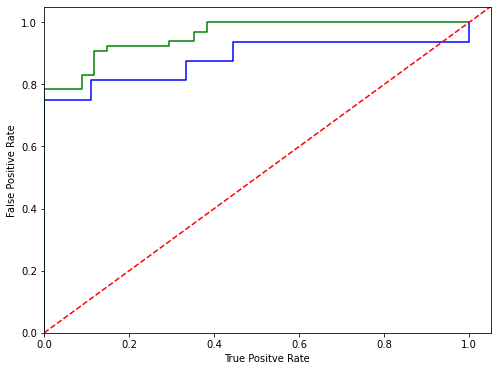

In [182]:
# Calculate metrics for evaluation
XGB_best_model.fit(X_train, y_train)

XGB_train_pred = XGB_best_model.predict(X_train)
XGB_test_pred = XGB_best_model.predict(X_test)
XGB_train_pred_proba = XGB_best_model.predict_proba(X_train)
XGB_test_pred_proba = XGB_best_model.predict_proba(X_test)

print("Classification report for XGBoost Classifier \n", metrics.classification_report(y_test, XGB_test_pred))

# Calculate classification metrics
XGB_train_accuracy = metrics.accuracy_score(y_train, XGB_train_pred)
XGB_test_accuracy = metrics.accuracy_score(y_test, XGB_test_pred)
XGB_train_auc = metrics.roc_auc_score(y_train, XGB_train_pred_proba[:,1])
XGB_test_auc = metrics.roc_auc_score(y_test, XGB_test_pred_proba[:,1])
XGB_train_fp, XGB_train_tp, _ = metrics.roc_curve(y_train, XGB_train_pred_proba[:,1])
XGB_test_fp, XGB_test_tp, _ = metrics.roc_curve(y_test, XGB_test_pred_proba[:,1])
XGB_train_roc_auc = metrics.auc(XGB_train_fp, XGB_train_tp)
XGB_test_roc_auc = metrics.auc(XGB_test_fp, XGB_test_tp)
XGB_train_precision, XGB_train_recall, XGB_train_f1_score, _ = precision_recall_fscore_support(
    y_train, XGB_train_pred, average='weighted')
XGB_test_precision, XGB_test_recall, XGB_test_f1_score, _ = precision_recall_fscore_support(
    y_test, XGB_test_pred, average='weighted')

print("Accuracy score: ", XGB_train_accuracy, "(Train), ", XGB_test_accuracy, "(Test)")
print("Area Under the Curve (AUC):", XGB_train_auc, "(Train)", XGB_test_auc, "(Test)")
print("Precision: ", XGB_train_precision, "(Train), ", XGB_test_precision, "(Test)")
print("Recall: ", XGB_train_recall, "(Train), ", XGB_test_recall, "(Test)")
print("f1-score: ", XGB_train_f1_score, "(Train), ", XGB_test_f1_score, "(Test)")

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(XGB_test_fp, XGB_test_tp, 'b', label='AUC (test) = %0.2f'%XGB_test_roc_auc)
plt.plot(XGB_train_fp, XGB_train_tp, 'g', label='AUC (train) = %0.2f'%XGB_train_roc_auc)
plt.plot([0,1.05], [0,1.05], 'r--')
plt.xlim([0,1.05])
plt.ylim([0,1.05])
plt.xlabel('True Positve Rate')
plt.ylabel('False Positive Rate')
plt.show()

### 4. SHAP Feature Analysis

In [183]:
# Initialising the SHAP explainer
model = XGBClassifier(gamma = 1, max_depth=2, tree_method='auto', booster='gbtree', verbosity=0, silent=True)
model.fit(X_train, y_train)
xgb_explain = shap.TreeExplainer (model)

In [184]:
# Calculate the Shap Values for the model features

shap_values_tr = xgb_explain.shap_values(X_train)
shap_values_ts = xgb_explain.shap_values(X_test)

#print(shap_values_tr.shape, shap_values_ts.shape)

In [185]:
features = list(df_train.columns)
features.remove('ER Status')

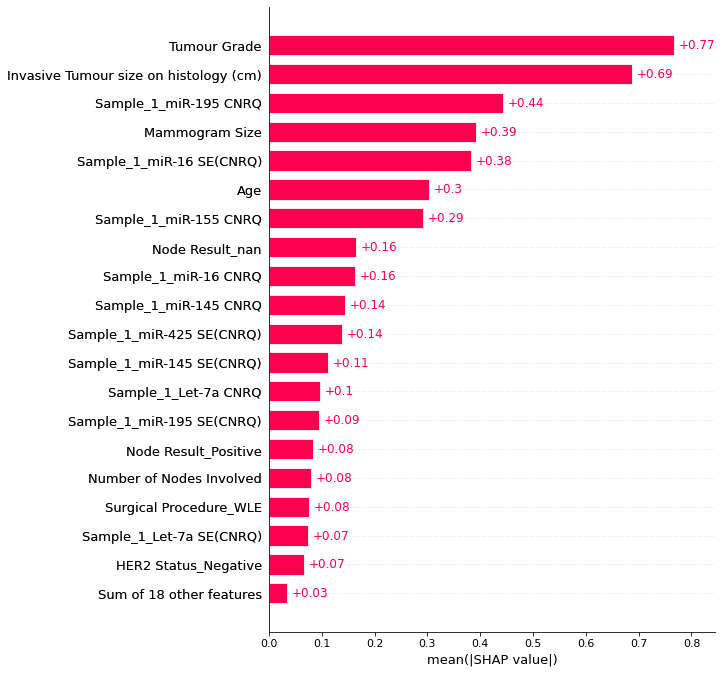

In [186]:
# Generate SHAP Global Variable Importance Plot
X = df_test.drop('ER Status', axis=1)
explain = shap.Explainer(model, X)
sh_values = explain(X)

shap.plots.bar(sh_values, max_display=20)

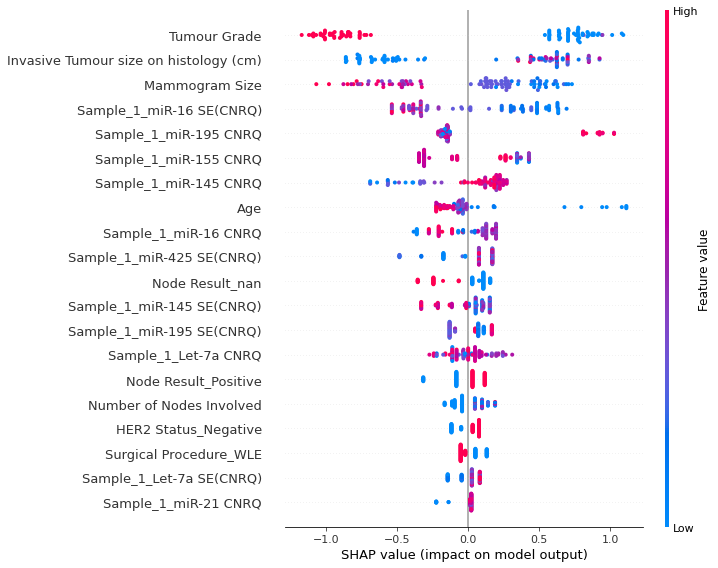

In [187]:
# Generate SHAP Summary Plot

shap.summary_plot(shap_values_tr, X_train, plot_type="dot", feature_names=features)

shap.summary_plot(shap_values_ts, X_test, plot_type="dot", feature_names=features)

In [188]:
# Select a random patient and further analyse their prediction of 'Final combined pCR status'
X_random = df_test.sample(1, random_state = 42)
X_sample = X_random.drop('ER Status', axis=1).values

#generate a prediction for the row
rand_pred = model.predict(X_sample)
rand_proba = model.predict_proba(X_sample)

print(f'Predicted Probability (no, yes): {rand_proba}')
print(f'Predicted ER Status (0 = no, 1 = yes): {rand_pred}','\n')

Predicted Probability (no, yes): [[0.24520022 0.7547998 ]]
Predicted ER Status (0 = no, 1 = yes): [1] 



In [189]:
# Generate TreeExplainer for Probability
xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', feature_dependence='independent', data=X_test)

In [190]:
# Calculate expected value of the model
expected_value = xgb_explain_prob.expected_value

In [191]:
expected_value

0.698467282727862

In [192]:
# Check that the model behaves as expected - need a 'True' here

# Generate SHAP Values for test data
shap_xgb_values_test = xgb_explain_prob.shap_values(X_test)

# Generate predctions from the SHAP values
y_test_shap_pred = (shap_xgb_values_test.sum(1) + expected_value) > 0.5

# Generate predictions from the model
y_test_xgb_pred = model.predict(X_test)

# Check that both methods generate the same results
print(np.array_equal(y_test_shap_pred, y_test_xgb_pred ))

True


In [193]:
# Predefined samples
indices = list(range(0,23))
sample_patients_idx = indices

In [194]:
# Generate FALSE NEGATIVEs
FN = (~y_test_shap_pred[sample_patients_idx]) & (y_test.iloc[sample_patients_idx] == 1).to_numpy()

In [195]:
shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

In [196]:
# Predefined samples
sample_patients_idx = [1,2,3,5,6]

In [197]:
FN = (~y_test_shap_pred[sample_patients_idx]) & (y_test.iloc[sample_patients_idx] == 1).to_numpy()

In [198]:
shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

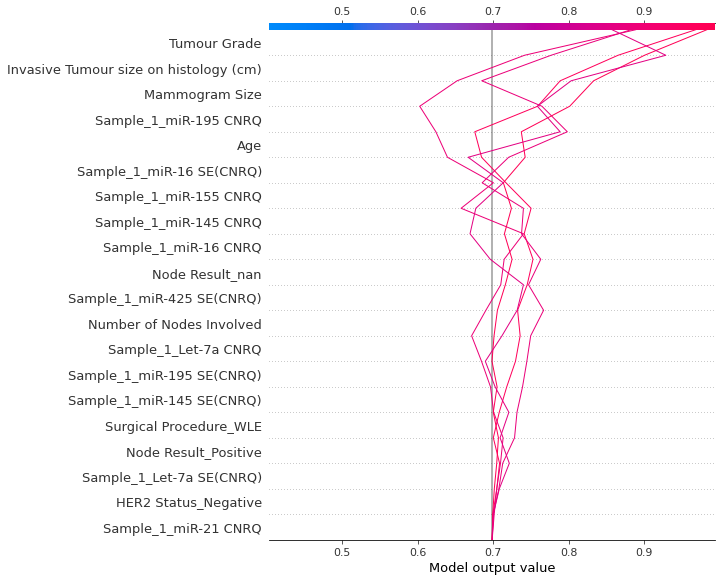

In [199]:
# Predefined samples
sample_patients_idx = [2,3,4,6,7]

shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

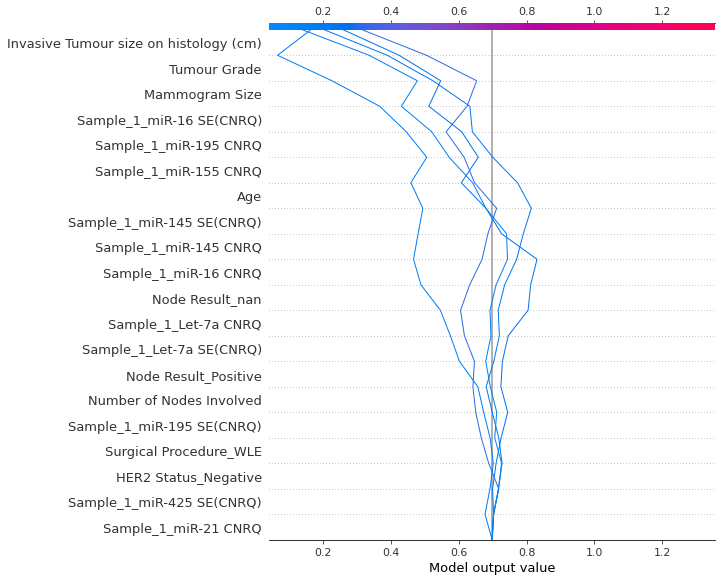

In [200]:
# Predefined samples
sample_patients_idx = [1,5,14,16,21]

shap.decision_plot(expected_value, 
                   shap_xgb_values_test[sample_patients_idx], 
                   df_test.iloc[sample_patients_idx], highlight=FN, feature_names=features)

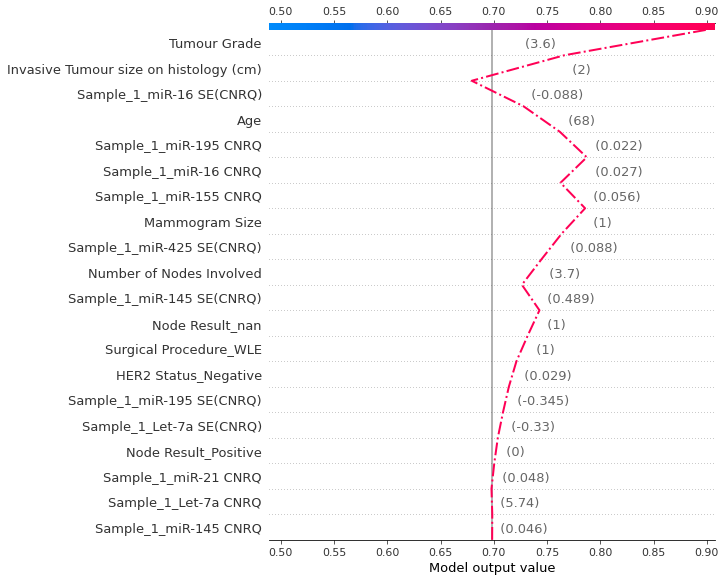

In [229]:
pred_pos = 9
shap.decision_plot(expected_value, shap_xgb_values_test[pred_pos], 
                   df_test.iloc[pred_pos], highlight=0, feature_names=features)

In [230]:
df_test.iloc[[pred_pos]]

Age  ER Status  Mammogram Size  Tumour Grade  \
61  68.0          1             3.6           2.0   

    Invasive Tumour size on histology (cm)  Number of Nodes Involved   NPI  \
61                                     3.7                       4.0  5.74   

    Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
61             -0.329859                  0.045697               0.489308   

    Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
61                   0.056306                0.33361   

    Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  Sample_1_miR-16 SE(CNRQ)  \
61                   0.026706             -0.088178                  0.021889   

    Sample_1_miR-195 CNRQ  Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
61              -0.345024                   0.048025             -0.275381   

    Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
61                  0.041194               0.088178   

    Sample_1_miR-425 SE(CNRQ)  HER2 Status_Negative  HER2 Status_Positive  \
61                   0.029486                     1                     0   

    HER2 Status_nan  Node Result_Negative  Node Result_Positive  \
61                0                     0                     1   

    Node Result_nan  Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
61                0                              1                       0   

    Surgical Procedure_nan  Final combined pCR status_No  \
61                       0                             1   

    Final combined pCR status_Yes  Final combined pCR status_nan  \
61                              0                              0   

    Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
61                                     0                                 0   

    Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
61                                    1                                 0   

    Tumour bed response to NACT_nan  
61                                0

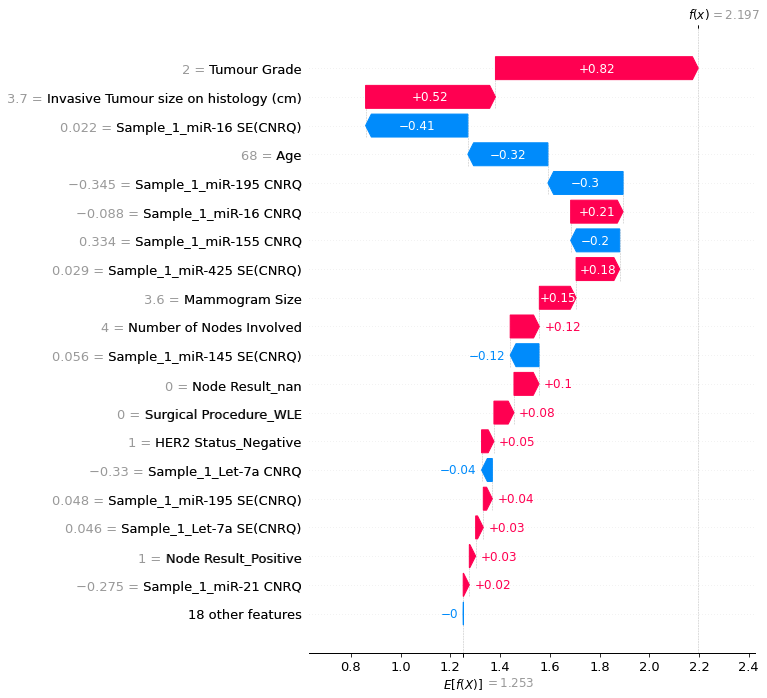

In [231]:
shap.plots.waterfall(sh_values[pred_pos], max_display=20)

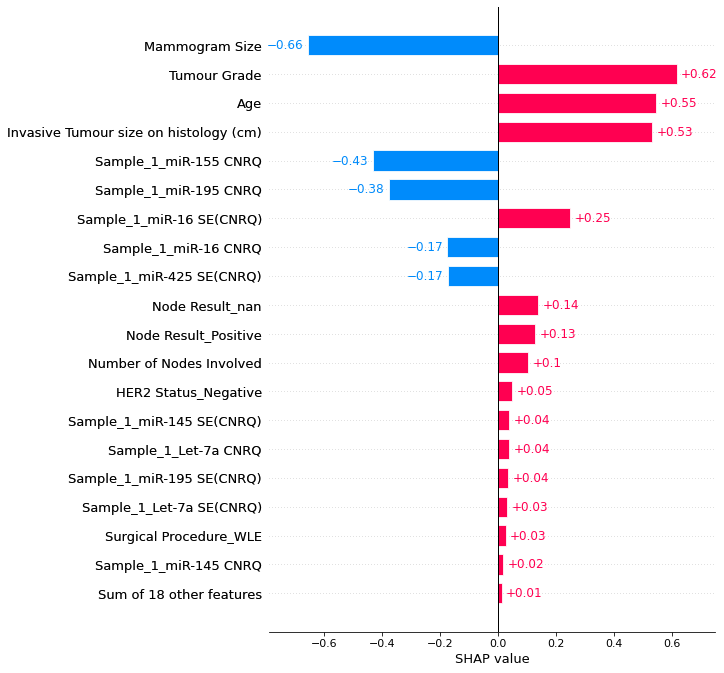

In [204]:
# Generate SHAP Local Variable Importance Plot

shap.plots.bar(sh_values[4], max_display=20)

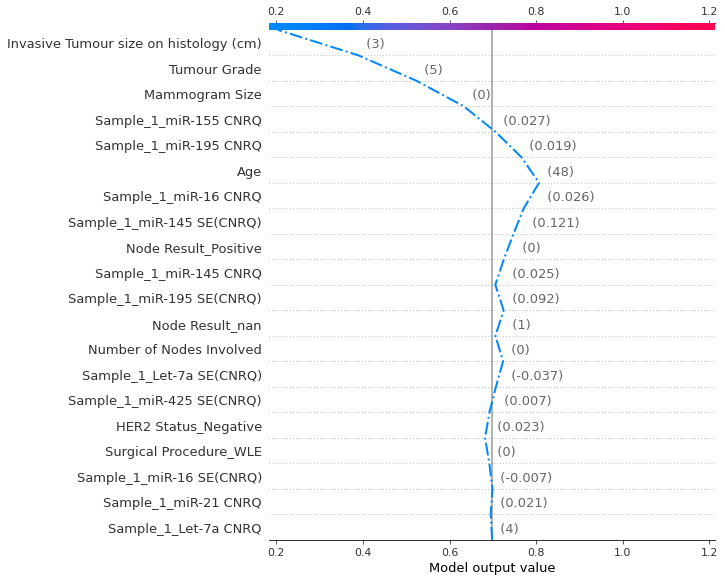

In [205]:
shap.decision_plot(expected_value, shap_xgb_values_test[1], df_test.iloc[1], highlight=0, feature_names=features)

In [206]:
df_test.iloc[[1]]

Age  ER Status  Mammogram Size  Tumour Grade  \
68  48.0          0             5.0           3.0   

    Invasive Tumour size on histology (cm)  Number of Nodes Involved  NPI  \
68                                     0.0                       0.0  4.0   

    Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
68             -0.037173                  0.024935               0.121349   

    Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
68                   0.027188              -0.001006   

    Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  Sample_1_miR-16 SE(CNRQ)  \
68                   0.026296                -0.007                  0.018777   

    Sample_1_miR-195 CNRQ  Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
68               0.091816                   0.020858             -0.114612   

    Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  \
68                  0.025023                  0.007   

    Sample_1_miR-425 SE(CNRQ)  HER2 Status_Negative  HER2 Status_Positive  \
68                   0.022731                     1                     0   

    HER2 Status_nan  Node Result_Negative  Node Result_Positive  \
68                0                     0                     1   

    Node Result_nan  Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
68                0                              0                       1   

    Surgical Procedure_nan  Final combined pCR status_No  \
68                       0                             0   

    Final combined pCR status_Yes  Final combined pCR status_nan  \
68                              1                              0   

    Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
68                                     1                                 0   

    Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
68                                    0                                 0   

    Tumour bed response to NACT_nan  
68                                0

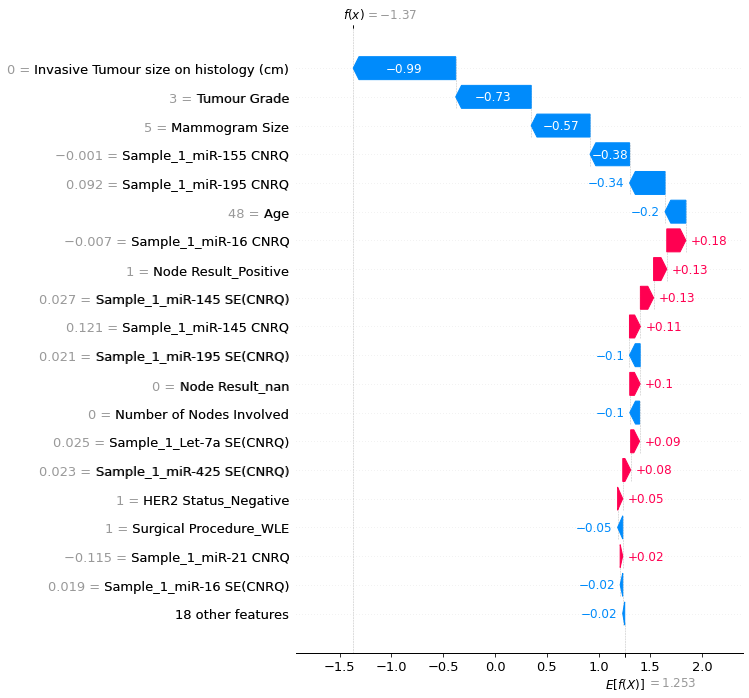

In [207]:
shap.plots.waterfall(sh_values[1], max_display=20)

In [208]:
shap.plots.bar(sh_values[1], max_display=20)

In [209]:
df_ = df_test.drop('Tumour Grade', axis=1)
sample_patient_ = df_.iloc[4]
sample_patient_data = sample_patient_.values.reshape(1,-1)

xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', data=X_test)

shap_values = xgb_explain_prob.shap_values(sample_patient_data)

shap.initjs()
shap.force_plot(xgb_explain.expected_value, shap_values, sample_patient_data, feature_names=features)

In [210]:
df_ = df_test.drop('Tumour Grade', axis=1)
sample_patient_ = df_.iloc[1]
sample_patient_data = sample_patient_.values.reshape(1,-1)

xgb_explain_prob = shap.TreeExplainer(model, model_output='probability', data=X_test)

shap_values = xgb_explain_prob.shap_values(sample_patient_data)

shap.initjs()
shap.force_plot(xgb_explain.expected_value, shap_values, sample_patient_data, feature_names=features)

In [211]:
df_shap = pd.DataFrame(data=shap_values, columns=features)

In [212]:
df_shap

Age  Mammogram Size  Tumour Grade  \
0 -0.036296        0.102184     -0.130329   

   Invasive Tumour size on histology (cm)  Number of Nodes Involved  NPI  \
0                               -0.186584                 -0.008296  0.0   

   Sample_1_Let-7a CNRQ  Sample_1_Let-7a SE(CNRQ)  Sample_1_miR-145 CNRQ  \
0             -0.004464                  0.017971               0.020829   

   Sample_1_miR-145 SE(CNRQ)  Sample_1_miR-155 CNRQ  \
0                   0.026771               -0.07669   

   Sample_1_miR-155 SE(CNRQ)  Sample_1_miR-16 CNRQ  Sample_1_miR-16 SE(CNRQ)  \
0                        0.0              0.036217                 -0.009404   

   Sample_1_miR-195 CNRQ  Sample_1_miR-195 SE(CNRQ)  Sample_1_miR-21 CNRQ  \
0              -0.046276                  -0.019813               0.00433   

   Sample_1_miR-21 SE(CNRQ)  Sample_1_miR-425 CNRQ  Sample_1_miR-425 SE(CNRQ)  \
0                       0.0                    0.0                    0.01476   

   HER2 Status_Negative  HER2 Status_Positive  HER2 Status_nan  \
0              0.004953                   0.0              0.0   

   Node Result_Negative  Node Result_Positive  Node Result_nan  \
0                   0.0              0.004612         0.019546   

   Surgical Procedure_Mastectomy  Surgical Procedure_WLE  \
0                            0.0               -0.021747   

   Surgical Procedure_nan  Final combined pCR status_No  \
0                     0.0                           0.0   

   Final combined pCR status_Yes  Final combined pCR status_nan  \
0                            0.0                            0.0   

   Tumour bed response to NACT_Complete  Tumour bed response to NACT_Good  \
0                                   0.0                               0.0   

   Tumour bed response to NACT_Partial  Tumour bed response to NACT_Poor  \
0                                  0.0                               0.0   

   Tumour bed response to NACT_nan  
0                              0.0

In [213]:
df_shap_key_values = df_shap.loc[: , [(df_shap[col] != 0).any() 
                                      for col in df_shap.columns]].transpose().sort_values(by=0, 
                                                                                           ascending=True)

In [214]:
df_shap_key_values

0
Invasive Tumour size on histology (cm) -0.186584
Tumour Grade                           -0.130329
Sample_1_miR-155 CNRQ                  -0.076690
Sample_1_miR-195 CNRQ                  -0.046276
Age                                    -0.036296
Surgical Procedure_WLE                 -0.021747
Sample_1_miR-195 SE(CNRQ)              -0.019813
Sample_1_miR-16 SE(CNRQ)               -0.009404
Number of Nodes Involved               -0.008296
Sample_1_Let-7a CNRQ                   -0.004464
Sample_1_miR-21 CNRQ                    0.004330
Node Result_Positive                    0.004612
HER2 Status_Negative                    0.004953
Sample_1_miR-425 SE(CNRQ)               0.014760
Sample_1_Let-7a SE(CNRQ)                0.017971
Node Result_nan                         0.019546
Sample_1_miR-145 CNRQ                   0.020829
Sample_1_miR-145 SE(CNRQ)               0.026771
Sample_1_miR-16 CNRQ                    0.036217
Mammogram Size                          0.102184

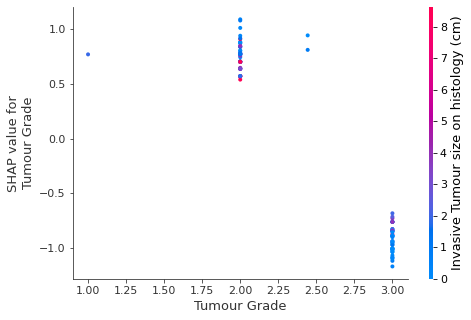

In [215]:
shap.dependence_plot('Tumour Grade', shap_values_tr, X_train, 
                     interaction_index="Invasive Tumour size on histology (cm)", feature_names=features)

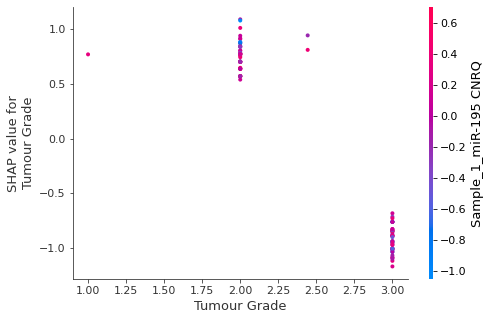

In [216]:
shap.dependence_plot('Tumour Grade', shap_values_tr, X_train, 
                     interaction_index="Sample_1_miR-195 CNRQ", feature_names=features)

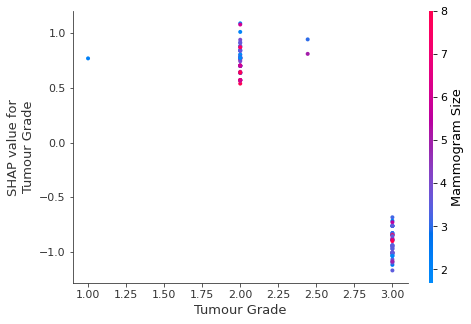

In [217]:
shap.dependence_plot('Tumour Grade', shap_values_tr, X_train, 
                     interaction_index="Mammogram Size", feature_names=features)

In [218]:
shap.dependence_plot('Tumour Grade', shap_values_tr, X_train, 
                     interaction_index="Sample_1_miR-16 SE(CNRQ)", feature_names=features)